In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import tensorflow as tf
import keras
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from keras.models import Model
from keras.layers import Input, Conv2D, LeakyReLU, BatchNormalization, MaxPool2D, Conv2DTranspose, concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [2]:
# Görüntülerin ve maskelerin bulunduğu dizinin yolu
IMAGE_PATH = 'C:/Users/iavcc/Desktop/Online Dersler/Görüntü İşleme/data2/kaggle_3m'

# Görüntülerin ve maskelerin yeniden boyutlandırılacağı boyutlar (genişlik, yükseklik)
IMAGE_SIZE = (256, 256)

# Eğitim için kullanılacak epoch sayısı (veri setinin eğitim sırasında kaç kez tam olarak kullanılacağı)
EPOCHS = 60

# Eğitim sırasında her bir iterasyonda kullanılacak veri parçası (batch) boyutu
BATCH_SIZE = 45


In [3]:
# Her bir görüntü ve maskenin yolunu tutmak için bir liste
paths = []

# IMAGE_PATH dizinindeki alt dizinleri tarar
for dirname in os.listdir(IMAGE_PATH):
    # Eğer alt dizin ise işlemi sürdür
    if os.path.isdir(os.path.join(IMAGE_PATH, dirname)):
        
        # Alt dizindeki dosyaları tarar
        for filename in os.listdir(os.path.join(IMAGE_PATH, dirname)):
            # Sadece '.tif' formatındaki dosyalar 'paths' listesine eklenir
            if filename.endswith('.tif'):
                paths.append(IMAGE_PATH + '/' + dirname + '/' + filename)

# 'paths' listesinin uzunluğunu ve her 5. dosya yolunu göstermek için (ilk 20 eleman)
len(paths), paths[:20:5]


(7858,
 ['C:/Users/iavcc/Desktop/Online Dersler/Görüntü İşleme\\data2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_1.tif',
  'C:/Users/iavcc/Desktop/Online Dersler/Görüntü İşleme\\data2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_12.tif',
  'C:/Users/iavcc/Desktop/Online Dersler/Görüntü İşleme\\data2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_14_mask.tif',
  'C:/Users/iavcc/Desktop/Online Dersler/Görüntü İşleme\\data2/kaggle_3m/TCGA_CS_4941_19960909/TCGA_CS_4941_19960909_17.tif'])

In [4]:
# 'paths' listesinden, görüntüler ve maskeler ayrılarak, ID'lerin ve tanıların (diagnoses) çıkarılmasıyla bir dataframe oluşturma işlevi
def data_frame(data):
    # 'mask.tif' ile bitmeyen yolları (görüntüleri) tutuyor
    images = list(filter(lambda x: not x.endswith('mask.tif'), data))
    # Her MRI'yi numaralarına göre sıralıyor
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-1][:-4]))
    # Hasta ID'lerine göre sıralama (her hastanın birden fazla MR görüntüsü var)
    images.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    
    # Görüntü ID'lerini tutuyor
    IDs = list(map(lambda x: x.rsplit('/', 3)[-1][:-4], images))

    # 'mask.tif' ile biten yolları (maskeleri) tutuyor
    masks = list(filter(lambda x: x.endswith('mask.tif'), data))
    # Her MRI maskesini numaralarına göre sıralıyor
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-2]))
    # Hasta ID'lerine göre sıralama (her hastanın birden fazla maskesi var)
    masks.sort(key=lambda x: int(x.rsplit('_', 3)[-3]))

    # Görüntüleri açıyor
    pixels = lambda x: Image.open(x)
    # Görüntüdeki en büyük piksel değerini seçiyor
    largest_pixel = lambda y: np.max(pixels(y))
    # Maskenin anormallik içerip içermediğini belirliyor (1 = anormallik var, 0 = anormallik yok)
    # Negatif bir görüntünün maskesi tamamen siyah bir görüntüdür
    diagnotic_function = lambda z: 1 if largest_pixel(z) > 0 else 0
    # Her görüntüye karşılık gelen tanıları (diagnoses) tutuyor
    diagnoses = list(map(lambda x: diagnotic_function(x), masks))

    # Bir dataframe oluşturuyor
    DataFrame = pd.DataFrame({'ID': IDs, 'Image': images, 'Mask': masks, 'Diagnosis': diagnoses})
    
    # İndeksleri eğitim (train), test ve doğrulama (validation) olarak bölüyor
    train_index, val_index = train_test_split(DataFrame.index.values.tolist(), test_size=0.19, random_state=42)
    val_index, test_index = train_test_split(val_index, test_size=0.12, random_state=42)
    
    # Eğitim, test ve doğrulama veri kümeleri oluşturuyor
    train_df, val_df, test_df = DataFrame.iloc[train_index], DataFrame.iloc[val_index], DataFrame.iloc[test_index]
    
    return train_df, val_df, test_df
    
# Veri kümelerini oluşturuyor
train_df, val_df, test_df = data_frame(paths)

# Eğitim, doğrulama ve test veri kümelerinin boyutlarını yazdırıyor
print(len(train_df), len(val_df), len(test_df))

# Eğitim veri kümesinin ilk birkaç satırını gösteriyor
train_df.head()


3182 657 90


ID  \
812   TCGA_DU_7302_19911203_33   
1550  TCGA_HT_7602_19951103_17   
2228  TCGA_DU_A5TR_19970726_31   
1108  TCGA_DU_5872_19950223_26   
3728  TCGA_FG_7643_20021104_17   

                                                  Image  \
812   C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...   
1550  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...   
2228  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...   
1108  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...   
3728  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...   

                                                   Mask  Diagnosis  
812   C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...          0  
1550  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...          0  
2228  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...          0  
1108  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...          0  
3728  C:/Users/iavcc/Desktop/Online Dersler/Görüntü ...          0

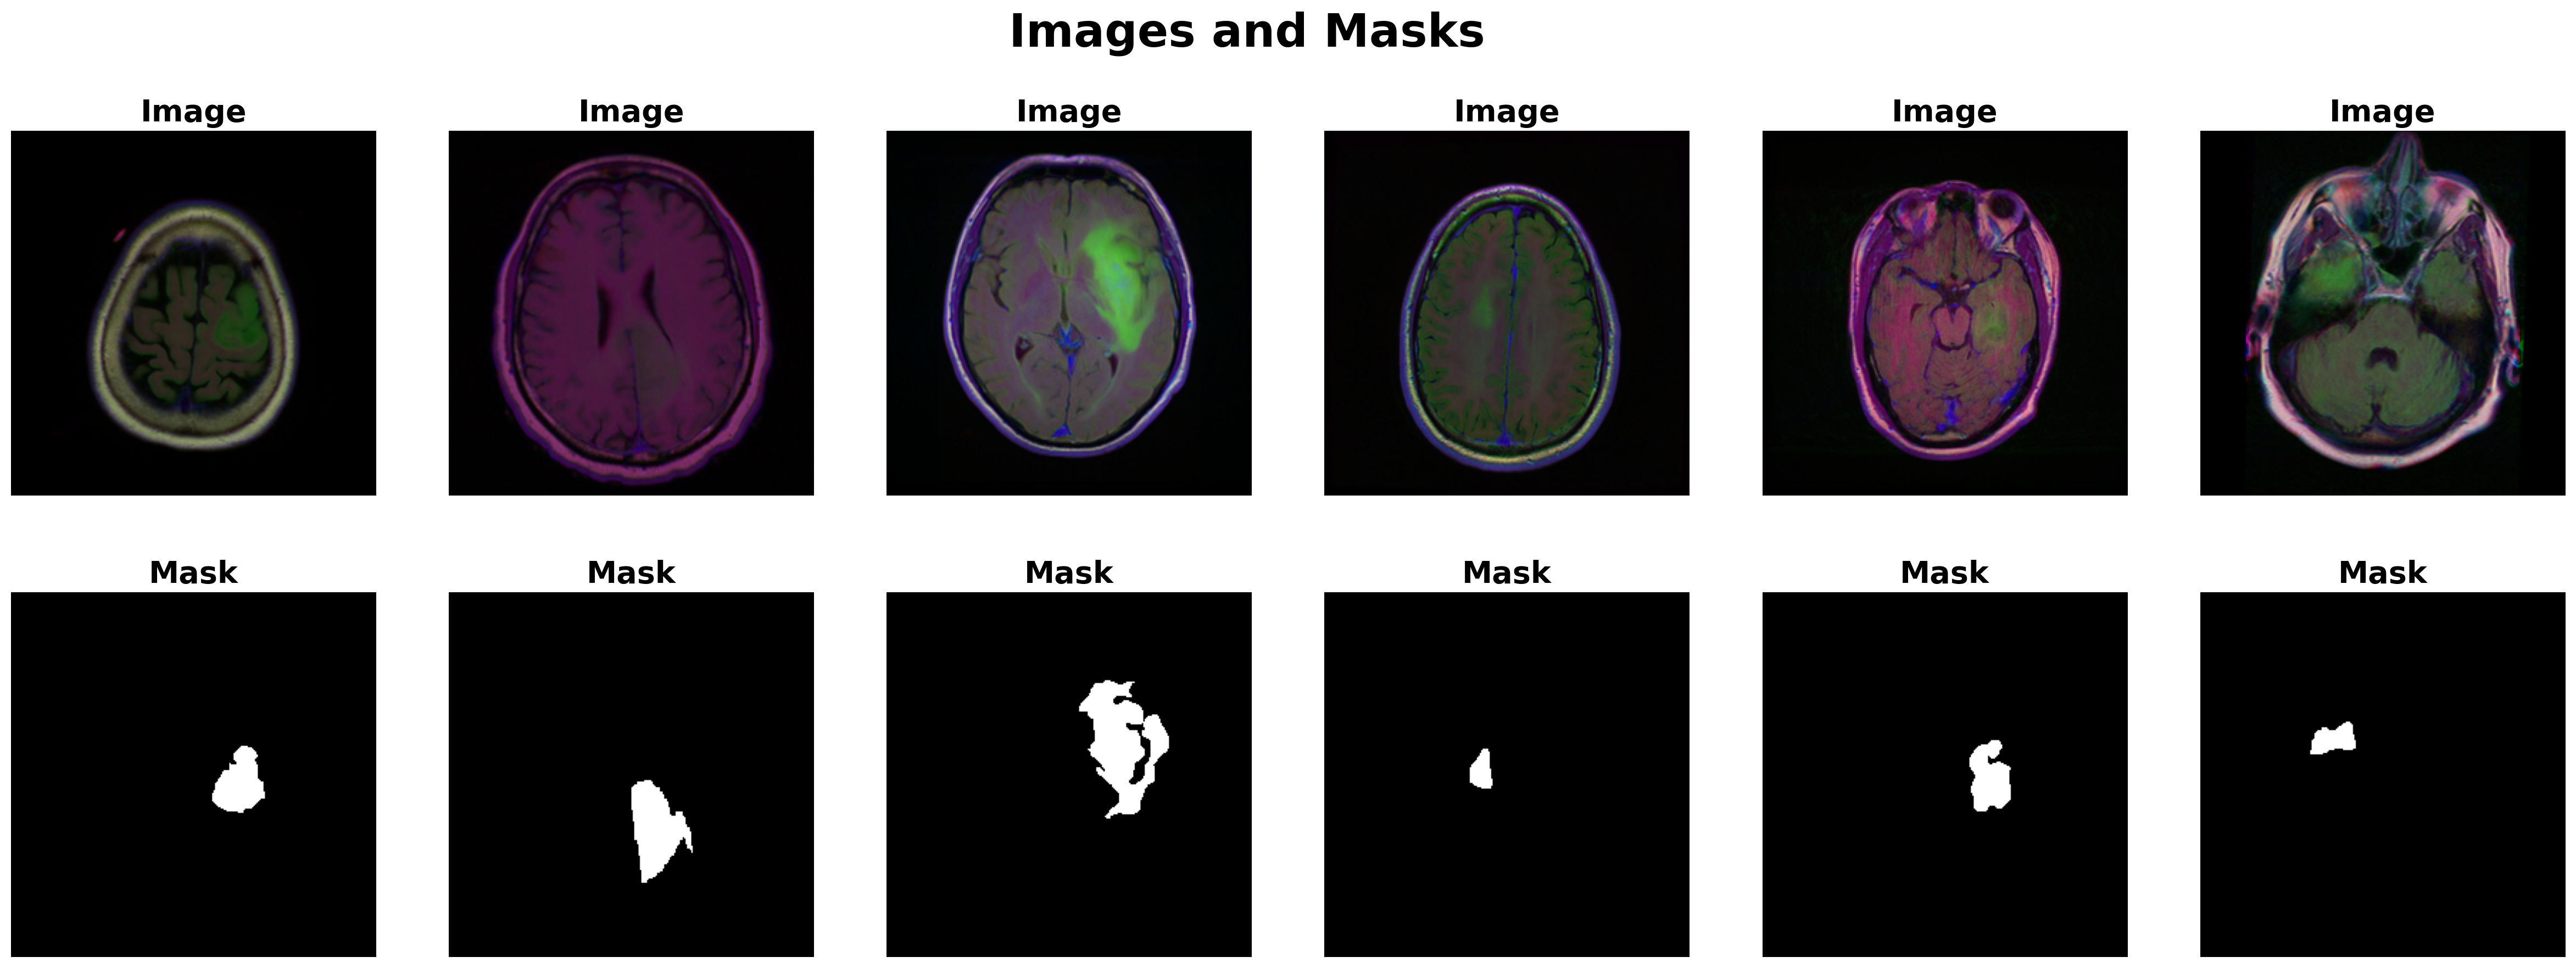

In [5]:
# Görüntüleri, maskeleri ve tahminleri (varsa) yan yana çizmek için bir fonksiyon
def plot_images_and_masks(images, masks, predictions=None, IoU_list=None):
    # Kaç adet görüntü ve maske çizileceğini belirliyor
    num_samples = len(images)
    # Tahmin dizisi fonksiyona verilmiş mi kontrol ediyor, yoksa 2 satır, tahminler varsa 3 satır olacak
    num_rows = 2 if type(predictions) == type(None) else 3
    
    # Şekli tanımlıyor (num_samples görüntü ve belirlenen satır sayısı kadar)
    fig, axes = plt.subplots(num_rows, num_samples,
                             figsize=(num_samples*5, num_samples+(num_rows*2)), dpi=200)
    
    for i in range(num_samples):
        # Görüntüyü çiziyor
        axes[0, i].imshow(Image.open(images[i]), cmap='gray')  # Görüntüyü gri tonlamada göster
        axes[0, i].set_title('Image', fontsize=20, fontweight='bold')  # Başlığı ayarla
        axes[0, i].axis('off')  # Eksenleri kapat
        
        # Maskeyi çiziyor
        axes[1, i].imshow(Image.open(masks[i]), cmap='gray')  # Maskeyi gri tonlamada göster
        axes[1, i].set_title('Mask', fontsize=20, fontweight='bold')  # Başlığı ayarla
        axes[1, i].axis('off')  # Eksenleri kapat
        
        # Tahmin verildiyse tahmini çiziyor
        if type(predictions) != type(None):
            axes[2, i].imshow(predictions[i], cmap='gray')  # Tahmin maskesini gri tonlamada göster
            # Tahminin başlığını çiziyor, IoU değerini de ekliyor
            axes[2, i].set_title(f'Prediction | IoU: {round(float(IoU_list[i]), 3)}',
                                 fontsize=19, fontweight='bold')
            axes[2, i].axis('off')  # Eksenleri kapat
             
    # Genel başlık ekliyor
    plt.suptitle('Images and Masks', fontsize=30, fontweight='bold')
    
    # Şekli gösteriyor
    plt.show()

# Eğitim veri setinde tanısı pozitif olan ilk 6 görüntüyü ve maskelerini çizdiriyor
plot_images_and_masks(train_df[train_df['Diagnosis'] == 1]['Image'].values[:6],
                      train_df[train_df['Diagnosis'] == 1]['Mask'].values[:6])


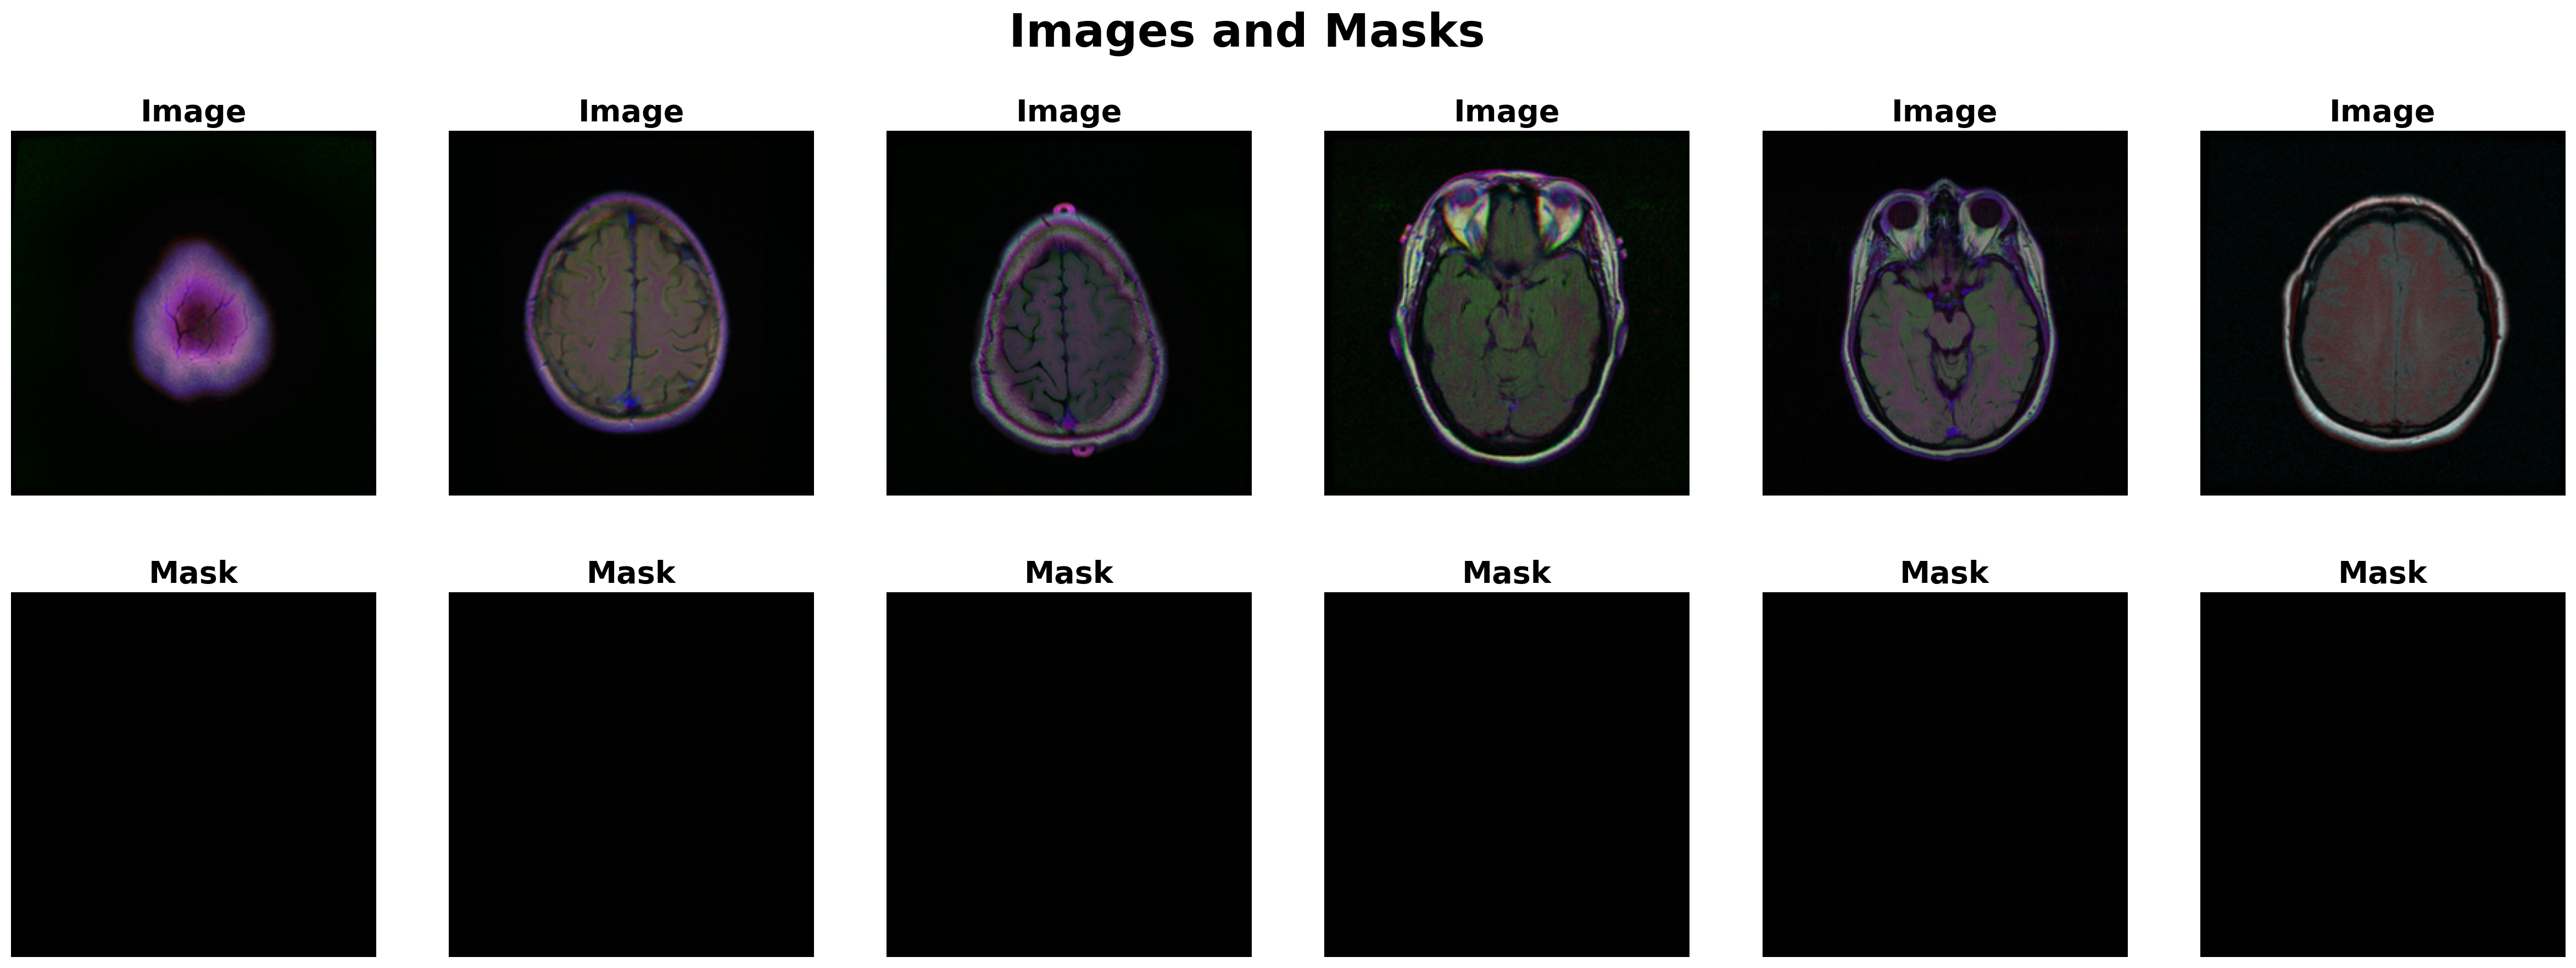

In [8]:
#Bu kod, tanısı negatif olan (yani maskede anormallik olmayan) ilk 6 görüntü ve maskeyi çizmek için kullanılıyor
plot_images_and_masks(train_df[train_df['Diagnosis'] == 0]['Image'].values[:6],
                      train_df[train_df['Diagnosis'] == 0]['Mask'].values[:6])

In [9]:
def plot_class_distribution(train_df, val_df, test_df):
    # Her veri setindeki tanı sütununa göre sınıf dağılımını sayar
    class_distribution_df1 = train_df['Diagnosis'].value_counts()
    class_distribution_df2 = val_df['Diagnosis'].value_counts()
    class_distribution_df3 = test_df['Diagnosis'].value_counts()
    
    # Sınıfların renkleri: mavi (negatif) ve kırmızı (pozitif)
    colors = ['#0504AA', '#ED0101']

    # Şekli tanımlar
    fig = go.Figure()

    # Her sınıf için çubukları ekler
    for class_label in class_distribution_df1.index:
        # Her sınıfın adını belirler (1: Pozitif, 0: Negatif)
        class_name = 'Positive' if class_label == 1 else 'Negative'
        
        # Her sınıf için yığılmış çubuk oluşturur
        fig.add_trace(go.Bar(
            x=['Training', 'Validation', 'Test'],  # X ekseninde veri kümeleri
            y=[class_distribution_df1.get(class_label, 0),  # Eğitim seti için sınıf sayısı
               class_distribution_df2.get(class_label, 0),  # Doğrulama seti için sınıf sayısı
               class_distribution_df3.get(class_label, 0)], # Test seti için sınıf sayısı
            name=f'{class_name}',  # Çubuğun ismi (Pozitif/Negatif)
            marker=dict(color=colors[class_label]),  # Renk ayarı
            opacity=0.75,  # Opaklık ayarı
            width=0.3  # Çubuk genişliği
        ))
    
    # Grafiğin yerleşimini günceller
    fig.update_layout(
        height=700,  # Grafik yüksekliği
        width=800,   # Grafik genişliği
        title_text="Class Distribution",  # Grafik başlığı
        title_font=dict(size=25, family='Balto'),  # Başlık yazı tipi ayarı
        title_x=0.5,  # Başlığı ortalar
        title_y=0.98,  # Başlık pozisyonu
        xaxis=dict(title='Dataframes', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),  # X ekseni başlığı ve yazı tipi
        yaxis=dict(title='Count', title_font=dict(family='Balto', size=19), tickfont=dict(family='Balto', size=19)),  # Y ekseni başlığı ve yazı tipi
        margin=dict(l=60, r=20, t=50, b=40),  # Kenar boşlukları
        legend=dict(x=0.73, y=0.98, traceorder='normal', orientation='h', font=dict(family='Balto')),  # Lejantın konumu
        barmode='stack'  # Çubukların yığılmış şekilde görüntülenmesi
                )
    
    # Grafiği gösterir
    fig.show()

# Eğitim, doğrulama ve test veri kümelerinde sınıf dağılımını çizdirir
plot_class_distribution(train_df, val_df, test_df)
